In [1]:
!pip install mmcv==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 22.1 MB/s eta 0:00:00
  Created wheel for mmcv: filename=mmcv-1.7.1-py2.py3-none-any.whl size=930716 sha256=5219147d98aebc111d809b7b1fac91dfbb36f14f097fc38377a10cc06ca34e9a
  Stored in directory: /root/.cache/pip/wheels/f8/f9/e3/7e8ab9b98ee9e91fcb677bea6a1ca23b755ddf87a982216acf
Successfully built mmcv
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.3.0
    Uninstalling platformdirs-3.3.0:
      Successfully uninstalled platformdirs-3.3.0


# Importing necessary libraries

In [2]:

from google.colab import drive
import shutil
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import math
from mmcv.cnn import constant_init, kaiming_init
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, Flatten, BatchNorm2d, Dropout

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from torchsummary import summary

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


# Loading the test dataset

In [3]:
drive.mount ('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [4]:
batch_size = 32

Loading our dataset from storage

In [5]:
# Transformer to tensor
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [6]:
rar_path = '/content/gdrive/MyDrive/new_test.zip'

In [7]:
!pip install patool
import patoolib
patoolib.extract_archive(rar_path, outdir="/content") #extracting dataset from zip file in drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.3 MB/s eta 0:00:00
patool: Extracting /content/gdrive/MyDrive/new_test.zip ...
patool: running /usr/bin/7z x -o/content -- /content/gdrive/MyDrive/new_test.zip
patool: ... /content/gdrive/MyDrive/new_test.zip extracted to `/content'.


'/content'

In [8]:
def load_dataset(d_path):
    dataset_manual = torchvision.datasets.ImageFolder(d_path, transform=transformer)
    print("Follwing classes are there : \n",dataset_manual.classes)
    train_loader_manual = torch.utils.data.DataLoader(dataset_manual)
    return train_loader_manual

In [9]:
test_dataset = load_dataset('/content/new_test')


Follwing classes are there : 
 ['Cercospora', 'Healthy', 'Miner', 'Phoma', 'Rust']


# Preparing the test dataset

In [10]:

test_dataset=test_dataset.dataset


In [11]:
classes = ['Cercospora', 'Healthy', 'Miner', 'Phoma', 'Rust'] # The 5 classes

In [12]:
torch.manual_seed(42) #setting random seed

In [13]:
# #Converting it to a DataLoader object


test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True)


In [14]:
test_loader

In [15]:
test_count = len(test_dataset)

In [16]:
# Image and batch counts
print('Testing Set - ' + str(len(test_dataset)) + ' images in ' + str(len(test_loader)) + ' batches' )


Testing Set - 350 images in 11 batches


## Image and label dimensions

In [17]:
for images, labels in test_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 256, 256])
Image label dimensions: torch.Size([32])


In [18]:
for images, labels in test_loader:
    print (labels)
    break

tensor([2, 4, 0, 0, 2, 4, 2, 2, 1, 4, 4, 4, 3, 2, 1, 2, 3, 3, 3, 1, 1, 2, 3, 1,
        1, 2, 0, 3, 2, 2, 3, 4])


# Setting up the proposed Network

In [19]:
class ScaledDotProductAttention(nn.Module):  #Multi-head attention module
    def forward(self, query, key, value, mask=None):
        dk = query.size()[1]
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dk)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        return torch.matmul(attention, value)


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, head_num, bias=True, activation=nn.ReLU()):
        super(MultiHeadAttention, self).__init__()
        if in_channels % head_num != 0:
            raise ValueError('`in_channels`({}) should be divisible by `head_num`({})'.format(in_channels, head_num))
        self.in_channels = in_channels
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=bias)
        self.linear_k = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=bias)
        self.linear_v = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=bias)
        self.linear_o = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=bias)
    def forward(self, x, mask=None):
        q, k, v = self.linear_q(x), self.linear_k(x), self.linear_v(x)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)
        q, k, v = self._reshape_to_batches(q), self._reshape_to_batches(k), self._reshape_to_batches(v)
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1, 1)
        y = ScaledDotProductAttention()(q, k, v, mask)
        y = self._reshape_from_batches(y)
        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    def _reshape_to_batches(self, x):
        batch_size, channels, height, width = x.size()
        sub_channels = channels // self.head_num
        return x.reshape(batch_size, self.head_num, sub_channels, height, width)\
                .permute(0, 2, 1, 3, 4)\
                .reshape(batch_size * self.head_num, sub_channels, height, width)

    def _reshape_from_batches(self, x):
        batch_size, channels, height, width = x.size()
        batch_size //= self.head_num
        out_channels = channels * self.head_num
        return x.reshape(batch_size, self.head_num, channels, height, width)\
                .permute(0, 2, 1, 3, 4)\
                .reshape(batch_size, out_channels, height, width)

In [20]:
class ConvBlock(nn.Module): # Convolutional + Relu + BatchNorm
    def __init__(self, in_channels,out_channels,kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.simple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, **kwargs),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)

        )
    def forward(self, xb):
        return self.simple_conv(xb)

In [21]:
class ConvWithMaxDrop(nn.Module): #Convolutional + Relu + BatchNorm + MaxPool + Dropout
    def __init__(self, in_channels,out_channels,kernel_size):
        super(ConvWithMaxDrop, self).__init__()
        self.conv_maxp_drop = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),

        )
    def forward(self, xb):
      return self.conv_maxp_drop(xb)

In [22]:
class InceptionBlock(nn.Module):  # Inception module
    def __init__(
        self,
        in_channels,
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5,
        out_pool,
    ):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1, padding=0),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)

In [23]:
def last_zero_init(m): #Global Context block
    if isinstance(m, nn.Sequential):
        constant_init(m[-1], val=0)
    else:
        constant_init(m, val=0)

class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_add', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            kaiming_init(self.conv_mask, mode='fan_in')
            self.conv_mask.inited = True

        if self.channel_add_conv is not None:
            last_zero_init(self.channel_add_conv)
        if self.channel_mul_conv is not None:
            last_zero_init(self.channel_mul_conv)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out

In [24]:
# Building the proposed network architecture

class ProposedModel(nn.Module):
    def __init__(self, aux_logits=True, num_classes=5):
      super(ProposedModel,self).__init__()
      self.aux_logits = aux_logits

      self.conv1 = ConvBlock(in_channels=3, out_channels=8, kernel_size=3)

      self.inception1 = InceptionBlock(in_channels=8, out_1x1=8, red_3x3=8, out_3x3=8, red_5x5=8, out_5x5=8, out_pool=8) #Inception

      self.conv2 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3)

      self.inception2 = InceptionBlock(in_channels=64, out_1x1=32, red_3x3=32, out_3x3=32, red_5x5=32, out_5x5=32, out_pool=32) #Second Inception block

      self.conv3 = ConvWithMaxDrop(in_channels=128, out_channels=192, kernel_size=3)

      self.conv4 = ConvBlock(in_channels=192, out_channels=160, kernel_size=3)

      self.gcblock = ContextBlock(inplanes=160, ratio=8) #Global Context

      self.conv5 = ConvWithMaxDrop(in_channels=160, out_channels=80, kernel_size=3)

      self.conv6 = ConvBlock(in_channels=80, out_channels=64, kernel_size=3)

      self.multi_head = MultiHeadAttention(in_channels=64, head_num=4) #Multi-head Attention module

      self.conv7 = ConvWithMaxDrop(in_channels=64, out_channels=32, kernel_size=3)

      self.fc1 = nn.Linear(25088, 256)


      self.fc2 = nn.Linear(256, 5)

    def forward(self, x):
      x = self.conv1(x)
      x = self.inception1(x)
      x = self.conv2(x)
      x = self.inception2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.gcblock(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.multi_head(x)
      x = self.conv7(x)
      x = x.reshape(x.shape[0], -1)
      x = F.relu(self.fc1(x))
      x = F.softmax(self.fc2(x))
      return x

# Setting up the network, loading the trained weights

In [25]:
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [26]:
device = torch.device('cpu')
device

device(type='cpu')

In [27]:
model = ProposedModel().to(device) # building the proposed network architecture

In [28]:
model.eval() # the architecture of the network

ProposedModel(
  (conv1): ConvBlock(
    (simple_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (inception1): InceptionBlock(
    (branch1): ConvBlock(
      (simple_conv): Sequential(
        (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (simple_conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ConvBlock(
        (simple_conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(8, eps=1e-0

In [29]:
summary(model,(3,256,256)) #proposed network summary of input size (256,256,3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
              ReLU-2          [-1, 8, 254, 254]               0
       BatchNorm2d-3          [-1, 8, 254, 254]              16
         ConvBlock-4          [-1, 8, 254, 254]               0
            Conv2d-5          [-1, 8, 254, 254]              72
              ReLU-6          [-1, 8, 254, 254]               0
       BatchNorm2d-7          [-1, 8, 254, 254]              16
         ConvBlock-8          [-1, 8, 254, 254]               0
            Conv2d-9          [-1, 8, 254, 254]              72
             ReLU-10          [-1, 8, 254, 254]               0
      BatchNorm2d-11          [-1, 8, 254, 254]              16
        ConvBlock-12          [-1, 8, 254, 254]               0
           Conv2d-13          [-1, 8, 254, 254]             584
             ReLU-14          [-1, 8, 2

<ipython-input-24-1fb6cd6af9a5>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


## Loading weights

In [30]:
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

In [31]:
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY) #model compiled with optimization algorithm and loss function
loss_function=nn.CrossEntropyLoss()

In [32]:
PATH = '/content/gdrive/MyDrive/proposed_model_size256_final.pt' #loading model weights from drive

In [33]:
checkpoint = torch.load(PATH, map_location=torch.device('cpu')) #loading and displaying the proposed network's performance in the last epoch
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']
train_accuracy = checkpoint['train_accuracy']
valid_accuracy = checkpoint['valid_accuracy']
epochs_completed = checkpoint['epochs_completed']

In [34]:
print(train_loss, valid_loss, train_accuracy, valid_accuracy)

0.05702671682687179 0.05770041843945335 0.9955312612416418 0.9866077561529295


In [35]:
print(epochs_completed) # number of epochs completed

120


### Model Testing

In [36]:
import numpy as np
from sklearn import metrics
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

In [37]:
y_true = []
y_pred = [] # model testing and storing predictions in y_pred
with torch.no_grad():
    for images,labels in test_loader:
        output = model(images)

        _,preds = torch.max(output,dim=1)
        y_true.extend(labels)
        y_pred.extend(preds)

<ipython-input-24-1fb6cd6af9a5>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


In [38]:
print(y_true)

[tensor(3), tensor(2), tensor(1), tensor(0), tensor(0), tensor(0), tensor(3), tensor(2), tensor(4), tensor(0), tensor(1), tensor(4), tensor(1), tensor(2), tensor(1), tensor(4), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(4), tensor(2), tensor(3), tensor(1), tensor(0), tensor(4), tensor(4), tensor(0), tensor(4), tensor(4), tensor(3), tensor(1), tensor(2), tensor(4), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(4), tensor(2), tensor(2), tensor(0), tensor(4), tensor(3), tensor(3), tensor(0), tensor(1), tensor(4), tensor(3), tensor(2), tensor(3), tensor(4), tensor(4), tensor(2), tensor(1), tensor(4), tensor(1), tensor(1), tensor(0), tensor(3), tensor(0), tensor(2), tensor(0), tensor(2), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(3), tensor(2), tensor(2), tensor(3), tensor(1), tensor(4), tensor(3), tensor(2), tensor(1), tensor(0), tensor(4), tensor(3), tensor(4), tensor(3), tensor(2), tensor(3), tensor(0), tensor(2), tensor(4), tensor(0)

In [39]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

Plotting AUC-ROC graph

In [40]:
class_labels = ['Cercospora', 'Healthy', 'Miner', 'Phoma', 'Rust']

def plot_roc_curve(y_true, y_pred, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    figure(figsize=(10, 10), dpi=300)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, (y_pred == i).astype(int))
        print(fpr[i])
        print(tpr[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i, color in zip(range(n_classes), ['blue', 'red', 'green', 'yellow', 'purple']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2.5, label='Class {0} (AUC = {1:0.4f})'.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    legend_properties = {'weight':'bold', "size": 15}
    plt.xticks(fontsize=15, weight="bold")
    plt.yticks(fontsize=15, weight="bold")
    plt.xlabel('False Positive Rate', fontsize=15, weight="bold")
    plt.ylabel('True Positive Rate', fontsize=15, weight="bold")
    # plt.title('ROC curve for multi-class classification')
    plt.legend(loc="lower right", prop=legend_properties)
    plt.savefig("proposed256_auc-roc_new_1806.png", dpi=300)
    plt.show()

[0. 0. 1.]
[0.         0.98571429 1.        ]
[0. 0. 1.]
[0. 1. 1.]
[0.         0.00357143 1.        ]
[0.         0.97142857 1.        ]
[0.         0.00714286 1.        ]
[0. 1. 1.]
[0. 0. 1.]
[0. 1. 1.]


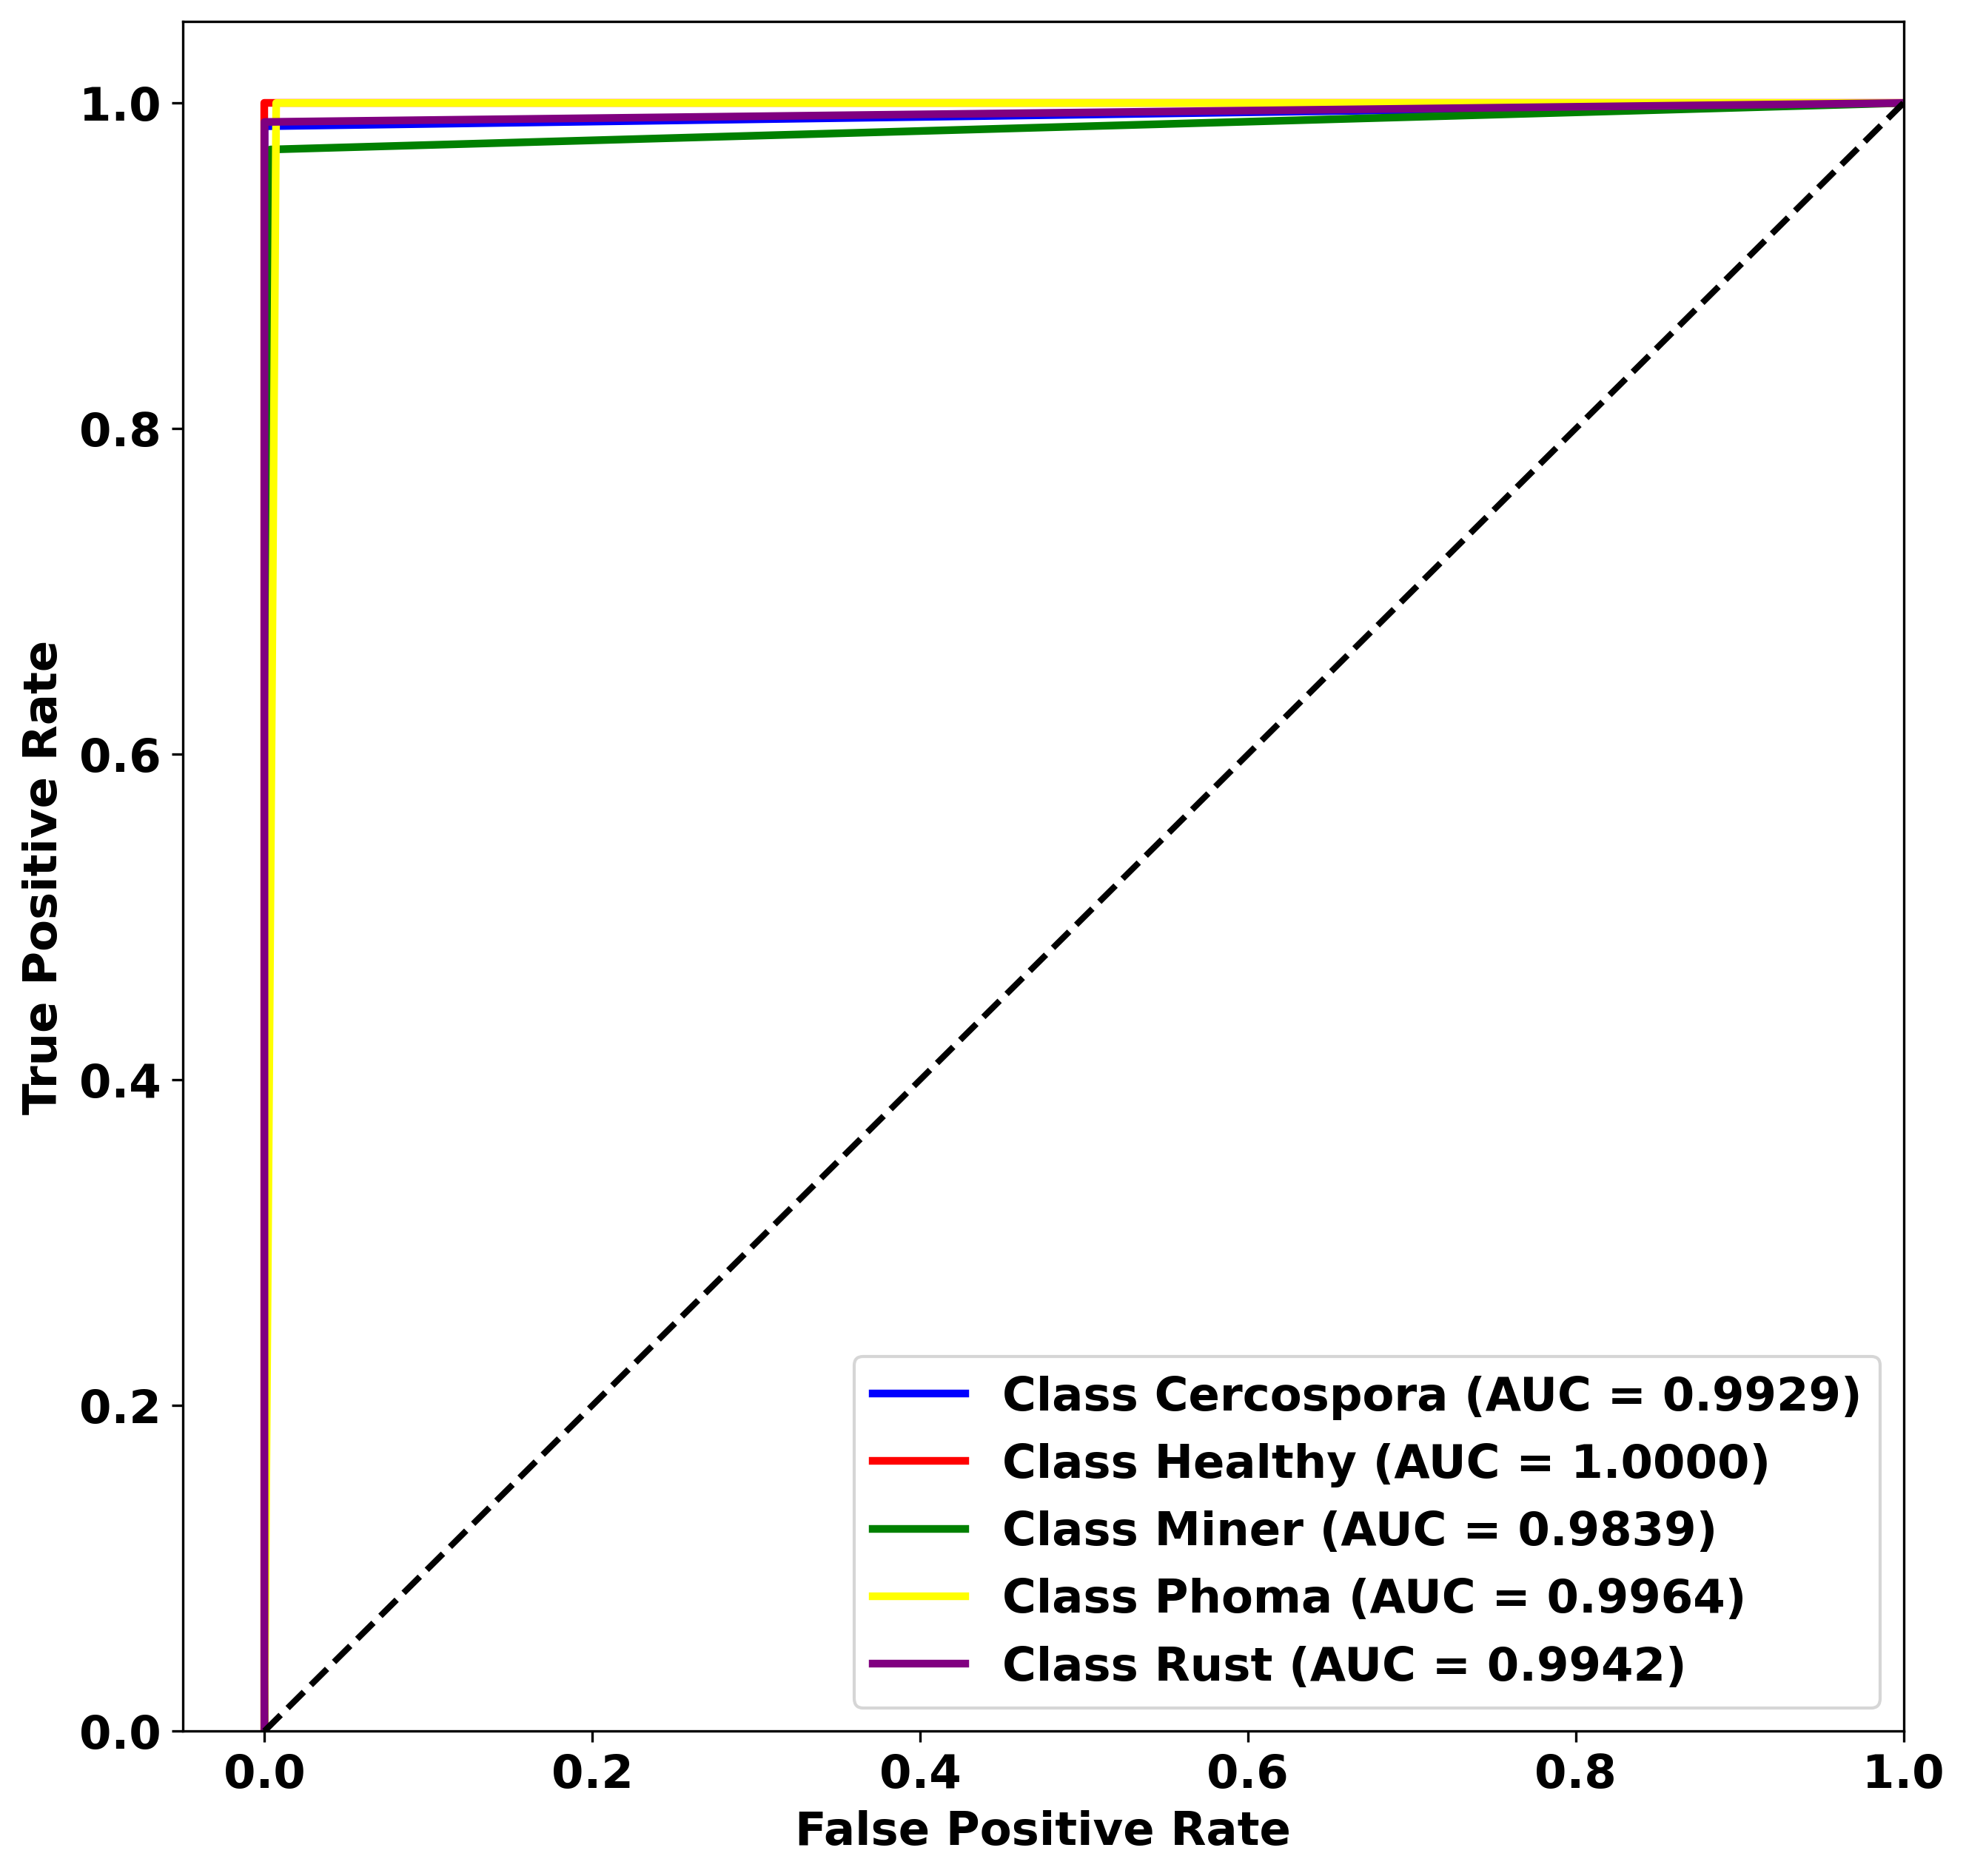

In [41]:
plot_roc_curve(y_true,y_pred,5)

In [42]:
#evaluating performance metrics like accuracy, precision, recall, f1 score and kappa scores

y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average=None)
f1 = metrics.f1_score(y_true, y_pred, average=None)
recall = metrics.recall_score(y_true, y_pred, average=None)
kappa = metrics.cohen_kappa_score(y_true, y_pred)

In [43]:
confusion_matrix=metrics.confusion_matrix(y_true,y_pred) # drawing confusion matrix

In [44]:
confusion_matrix

array([[69,  0,  0,  1,  0],
       [ 0, 70,  0,  0,  0],
       [ 1,  0, 68,  0,  1],
       [ 0,  0,  1, 69,  0],
       [ 0,  0,  1,  0, 69]])

In [45]:
confusion_matrix.shape

(5, 5)

In [46]:
kappa #cohen kappa score

0.9820154675483724

In [47]:
res = []
for l in [0,1,2,3,4]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[1]])

In [48]:
import pandas as pd

In [49]:
spec=0 # calculating the specificity
for i in res:
  spec = spec + i[1]

specificity=spec/5

In [50]:
y_true = torch.nn.functional.one_hot(torch.tensor(y_true),num_classes=len(np.unique(y_true))).numpy()
y_pred = torch.nn.functional.one_hot(torch.tensor(y_pred),num_classes=len(np.unique(y_pred))).numpy()

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred, pos_label=1)

In [51]:
print(f'Accuracy: {accuracy:.4f}, Precision: {np.mean(precision):.4f}, F1 Score: {np.mean(f1):.4f}, Recall: {np.mean(recall):.4f}, Specificity: {specificity:.4f}, CohenKappa Score: {kappa:.4f}')

Accuracy: 0.9857, Precision: 0.9857, F1 Score: 0.9855, Recall: 0.9854, Specificity: 0.9964, CohenKappa Score: 0.9820


### Confusion Matrix

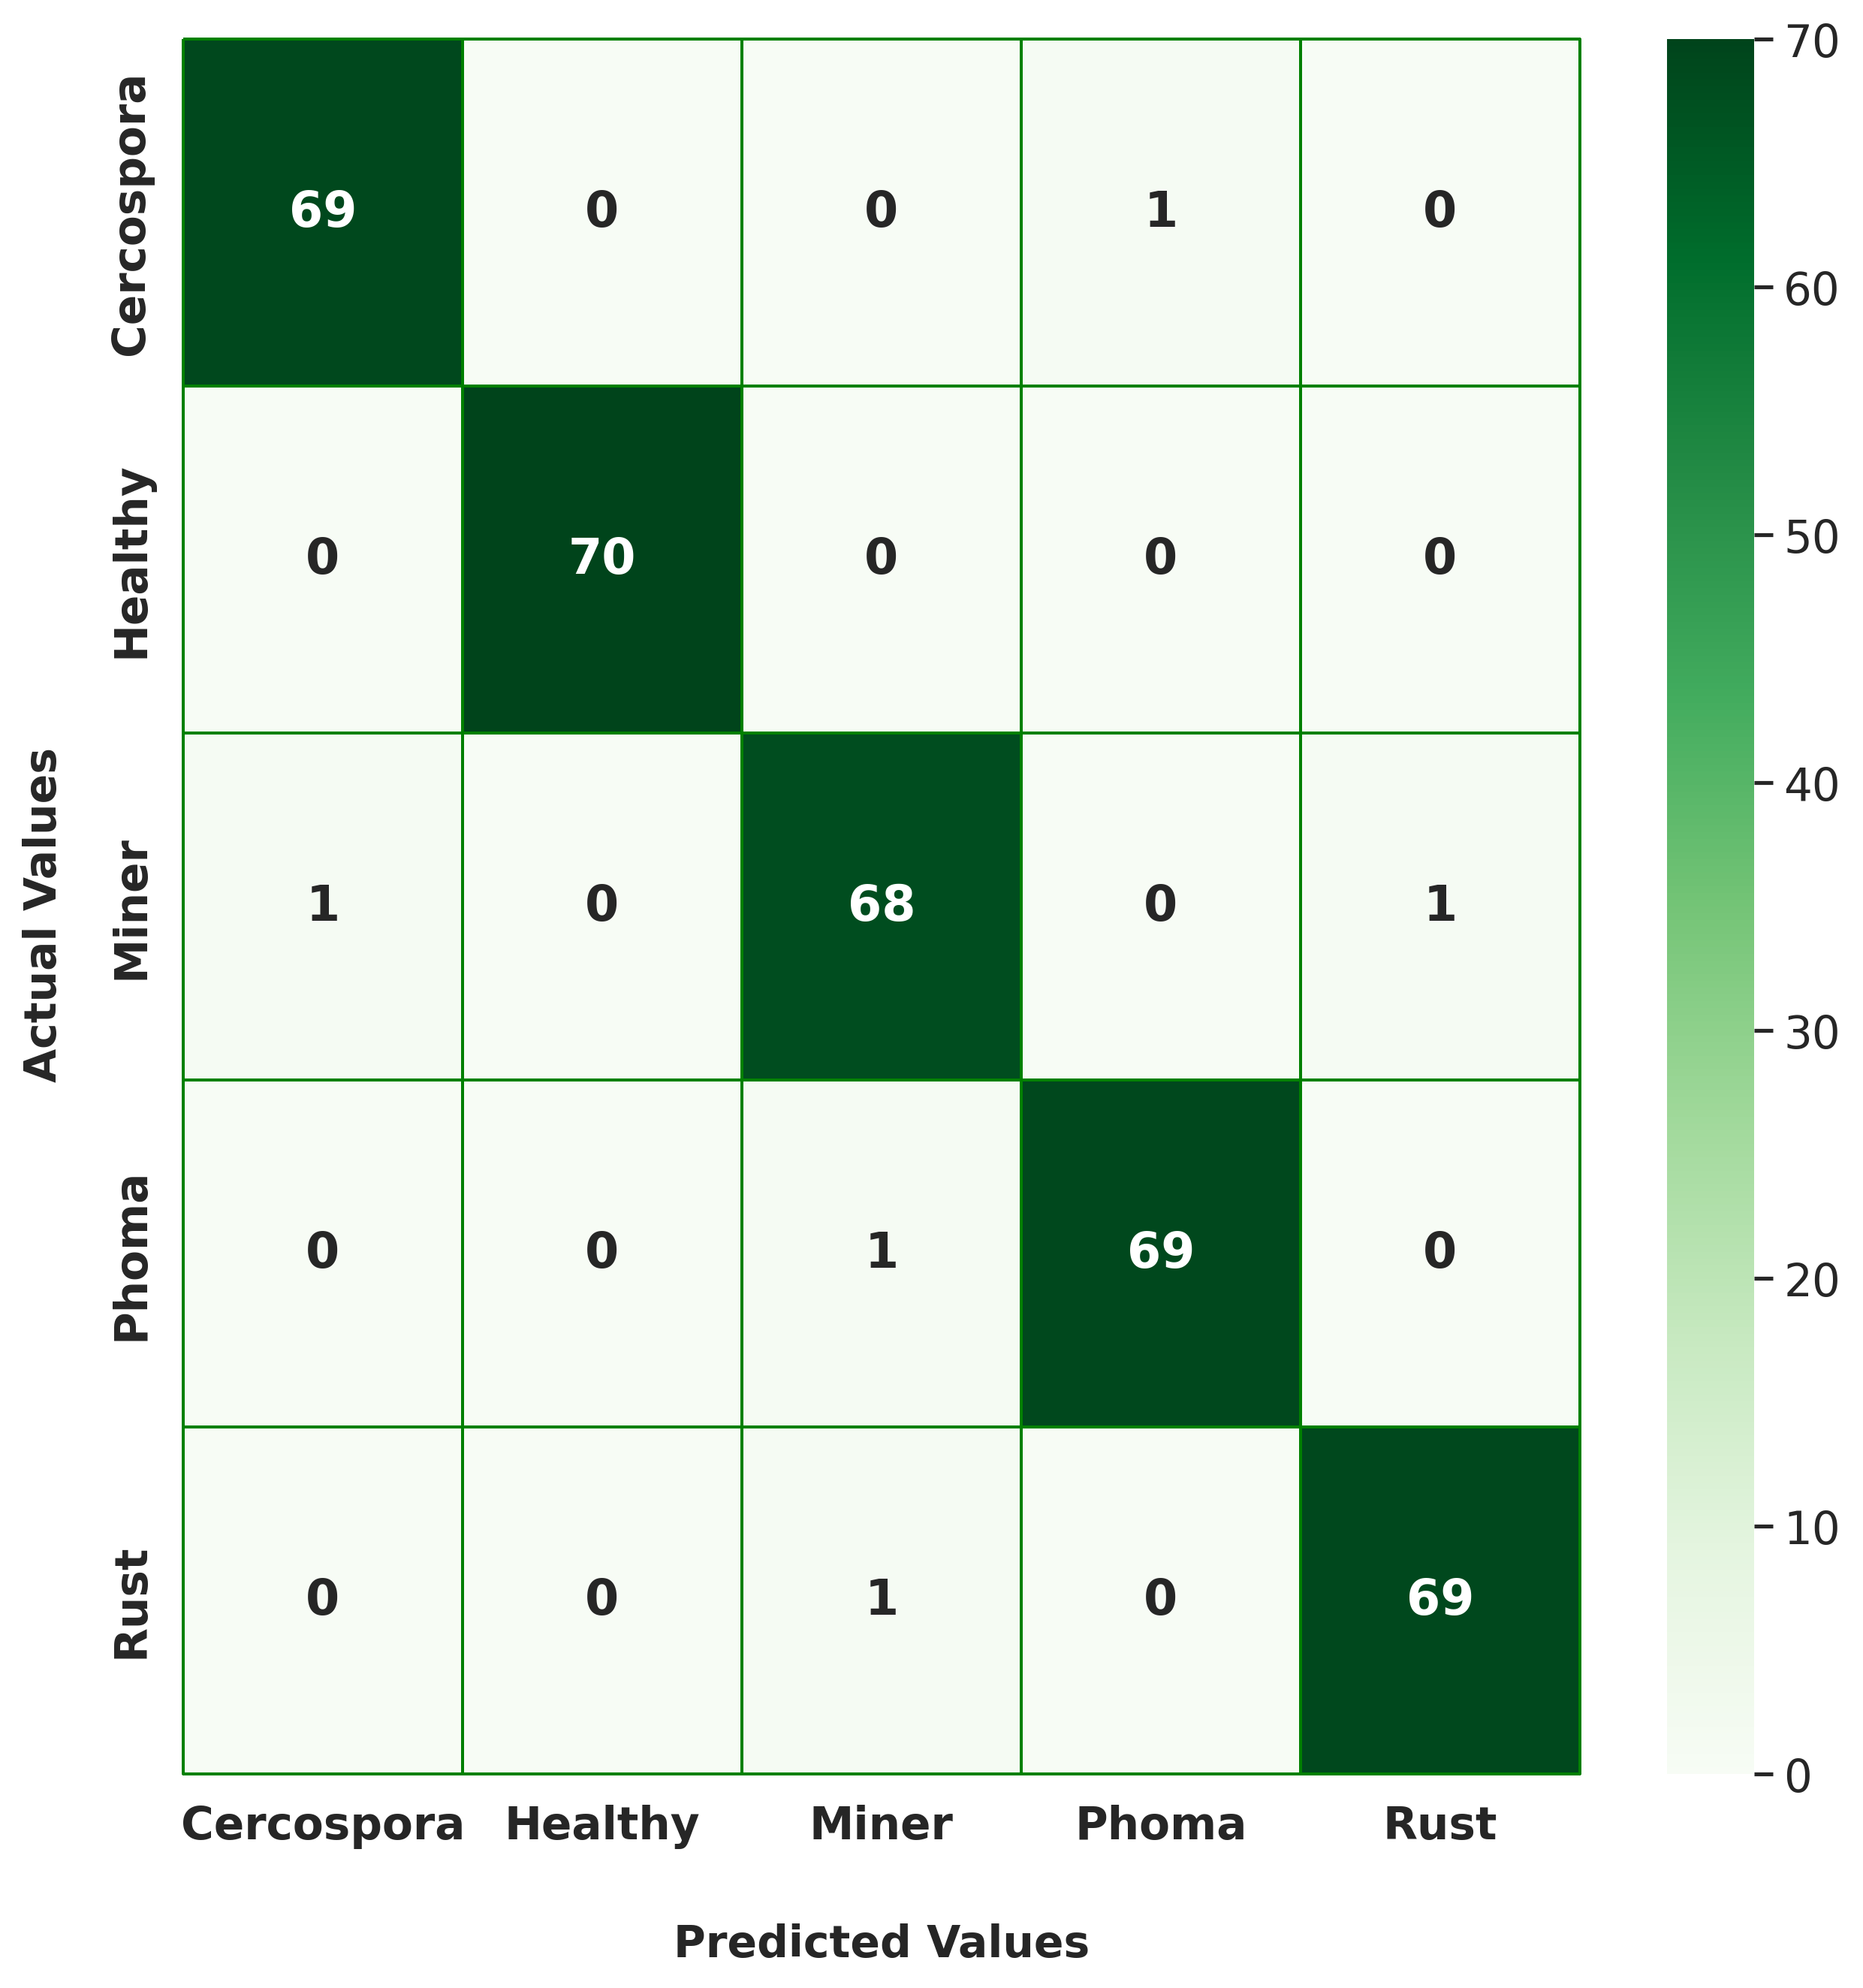

In [52]:
#displaying the confusion matrix using seaborn

import seaborn as sns
from matplotlib.pyplot import figure
sns.set(font_scale=1.3)
figure(figsize=(10, 10), dpi=300)

ax = sns.heatmap(confusion_matrix, annot=True, fmt='', cmap='Greens', linewidths=0.5, linecolor='green',
                 clip_on=False, annot_kws={"weight": "bold"})
# ax.set_title('Confusion Matrix of the proposed model\n\n');
ax.set_xlabel('\nPredicted Values', weight="bold",fontsize=14, labelpad = 8)
ax.set_ylabel('Actual Values ', weight="bold",fontsize=14, labelpad = 14);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Cercospora', 'Healthy', 'Miner', 'Phoma', 'Rust'], weight="bold")
ax.yaxis.set_ticklabels(['Cercospora', 'Healthy', 'Miner', 'Phoma', 'Rust'], weight="bold")


plt.savefig("/content/proposed256_cm_new.png", dpi=300)

## Display the visualization of the Confusion Matrix.
plt.show()